## Noise Comparison Table

Run the script `noise_comparison_table.py` before running this notebook.

In [1]:
from typing import Callable, List
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [2]:
# anisotropic_noise_count.csv is a line-seperated list of python objects
# parse to a nested array 'data'
categories = ['Father Avg', 'Mother Avg', 'Other Avg', 'Father Max', 'Mother Max', 'Other Max']
budget_list: List[float] = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]

# pkl files are saved in './noise_comparison/anisotropic_Father Avg.pkl' etc
dfs = {}
dfs['anisotropic'] = {c: pd.read_pickle(f'./noise_comparison/anisotropic_{c}.pkl') for c in categories}
dfs['hybrid'] = {c: pd.read_pickle(f'./noise_comparison/hybrid_{c}.pkl') for c in categories}

tables = {}

for noise_type in ['anisotropic', 'hybrid']:
    tables[noise_type] = pd.DataFrame(index=budget_list, columns=categories)
    for c in categories:
        for b in budget_list:
            tables[noise_type].loc[b, c] = np.mean((dfs[noise_type][c])[dfs[noise_type][c]['mi'] == b]['noise'])

variances = {}

for noise_type in ['anisotropic', 'hybrid']:
    variances[noise_type] = pd.DataFrame(index=budget_list, columns=categories)
    for c in categories:
        for b in budget_list:
            variances[noise_type].loc[b, c] = np.mean((dfs[noise_type][c])[dfs[noise_type][c]['mi'] == b]['variances'])

means = {}

for noise_type in ['anisotropic', 'hybrid']:
    means[noise_type] = pd.DataFrame(index=budget_list, columns=categories)
    for c in categories:
        for b in budget_list:
            means[noise_type].loc[b, c] = np.mean((dfs[noise_type][c])[dfs[noise_type][c]['mi'] == b]['mean'])

tables['anisotropic']

,Father Avg,Mother Avg,Other Avg,Father Max,Mother Max,Other Max
0.015625,992.979414,4750.480987,8861.680108,385.118667,317.533466,1933.468417
0.031250,997.100619,2068.122114,4384.559644,241.424827,167.572223,950.751672
0.062500,280.168093,1199.458608,2234.204432,116.675932,80.800848,476.794932
0.125000,212.496496,529.254911,1107.922728,52.879748,39.827445,236.253296
0.250000,149.257566,259.903041,561.153038,28.300572,19.810089,121.661193
0.500000,73.503614,120.859074,274.560589,20.197097,10.595208,58.928784
1.000000,29.607492,66.31227,132.183632,7.718791,4.625353,29.552716
2.000000,8.611179,36.124818,68.298727,3.825714,2.545882,14.83467
4.000000,3.954048,18.744483,35.031621,2.125378,1.276861,7.595153


In [3]:
import csv
for noise_type in ['anisotropic', 'hybrid']:
    with open(f'noise_comparison/{noise_type}_table.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tables[noise_type].values)

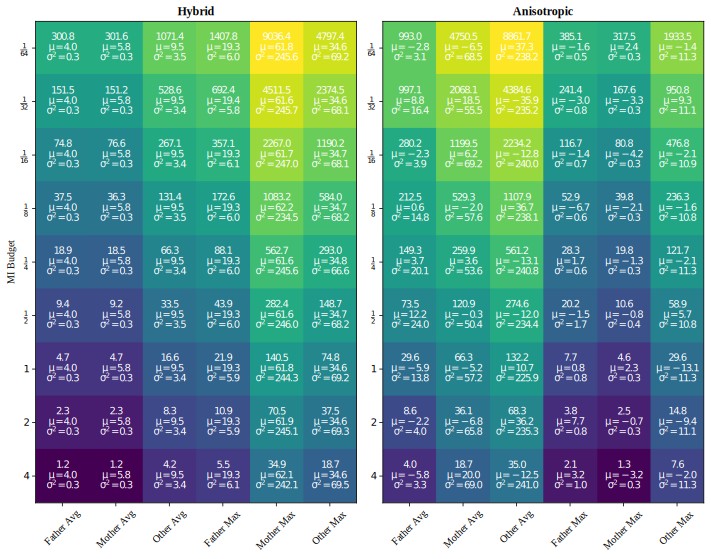

In [4]:
# plot a heatmap for anisotropic
# x axis: category
# y axis: budget

from matplotlib.colors import LogNorm

budget_list_labels = [r'$\frac{1}{val}$'.replace("val", str(int(1/val))) if val < 1 else f'${int(val)}$' for val in budget_list]

fig, axs = plt.subplots(1, 2, figsize=(10,8))

min_val, max_val = np.min([np.min(tables[noise_type].values) for noise_type in ['hybrid', 'anisotropic']]), np.max([np.max(tables[noise_type].values) for noise_type in ['hybrid', 'anisotropic']])

for noise_type in ['hybrid', 'anisotropic']:
    if noise_type == 'hybrid':
        ax = axs[0]
    elif noise_type == 'anisotropic':
        ax = axs[1]
    
    im = ax.imshow(tables[noise_type].values.astype(float), cmap='viridis', norm=LogNorm(vmax=max_val, vmin=min_val))

    ax.set_xticks(np.arange(len(categories)), categories, rotation=45)
    ax.set_yticks(np.arange(len(budget_list)), budget_list_labels)

    for i in range(len(budget_list)):
        for j in range(len(categories)):
            text = ax.text(j, i, f'${tables[noise_type].values[i, j]:.1f}$\n$\\mu={means[noise_type].values[i, j]:.1f}$\n$\\sigma^2={variances[noise_type].values[i, j]:.1f}$', ha='center', va='center', color='white')

    ax.set_title(f'{noise_type.capitalize()}')
    if noise_type == 'hybrid':
        ax.set_ylabel('MI Budget')

fig.tight_layout()

fig.savefig('figs/noise_comparison_table.png', bbox_inches='tight')